# How bagging lowers model variance

## Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
from numpy.random import choice, normal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [3]:
sns.set_style('white')
np.random.seed(seed=42)

In [4]:
results_path = Path('results', 'random_forest')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Bagged Decision Trees

To apply bagging to decision trees, we create bootstrap samples from our training data by repeatedly sampling with replacement, then train one decision tree on each of these samples, and create an ensemble prediction by averaging over the predictions of the different trees.

Bagged decision trees are usually grown large, that is, have many levels and leaf nodes and are not pruned so that each tree has low bias but high variance. The effect of averaging their predictions then aims to reduce their variance. Bagging has been shown to substantially improve predictive performance by constructing ensembles that combine hundreds or even thousands of trees trained on bootstrap samples.

To illustrate the effect of bagging on the variance of a regression tree, we can use the `BaggingRegressor` meta-estimator provided by `sklearn`. It trains a user-defined base estimator based on parameters that specify the sampling strategy:

- `max_samples` and `max_features` control the size of the subsets drawn from the rows and the columns, respectively
- `bootstrap` and `bootstrap_features` determine whether each of these samples is drawn with or without replacement

## A wiggly function to learn

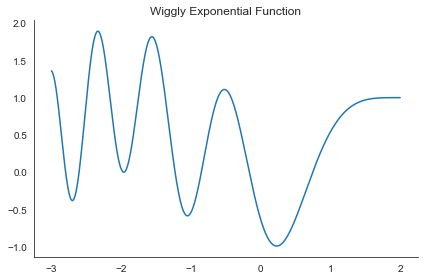

In [5]:
def f(x):
    return np.exp(-(x+2) ** 2) + np.cos((x-2)**2) #定义一个摆动函数 （真实函数）

x = np.linspace(-3, 2, 1000)  
y = pd.Series(f(x), index=x)
y.plot(title='Wiggly Exponential Function')
sns.despine()
plt.tight_layout();

## Simulate Training

The following example uses the preceding exponential function `f(x)` to generate training samples for a single DecisionTreeRegressor and a BaggingRegressor ensemble that consists of ten trees, each grown ten levels deep. Both models are trained on the random samples and predict outcomes for the actual function with added noise.

Since we know the true function, we can decompose the mean-squared error into bias, variance, and noise, and compare the relative size of these components for both models according to the following breakdown:

For 100 repeated random training and test samples of 250 and 500 observations each, we find that the variance of the predictions of the individual decision tree is almost twice as high as that for the small ensemble of 10 bagged trees based on bootstrapped samples:

In [6]:
test_size = 500 #测试集大小
train_size = 250 #训练集大小
reps = 100

noise = .5  # noise relative to std(y) 噪声相对于标准差的比例
noise = y.std() * noise #噪声为0.5个标准差大小

X_test = choice(x, size=test_size, replace=False) #生成测试集

max_depth = 10  #每棵树的深度为10
n_estimators=10 #基估计器数目10

tree = DecisionTreeRegressor(max_depth=max_depth) 
bagged_tree = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators)
learners = {'Decision Tree': tree, 'Bagging Regressor': bagged_tree}

predictions = {k: pd.DataFrame() for k, v in learners.items()}
for i in range(reps): #重复预测100次
    X_train = choice(x, train_size) #生成训练集X
    y_train = f(X_train) + normal(scale=noise, size=train_size) #训练集y
    for label, learner in learners.items():
        learner.fit(X=X_train.reshape(-1, 1), y=y_train) #用训练集拟合模型
        preds = pd.DataFrame({i: learner.predict(X_test.reshape(-1, 1))}, index=X_test) #用拟合的模型在测试集上预测y_hat
        predictions[label] = pd.concat([predictions[label], preds], axis=1) 

In [7]:
predictions['Decision Tree']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
-0.392392,1.093966,0.484015,0.948455,0.847429,0.558404,1.024993,0.181146,1.100584,0.415429,0.692365,...,1.233909,0.697206,0.730367,0.825113,1.038004,0.671742,1.049839,0.906213,1.091349,1.211063
0.688689,0.224270,0.687644,0.047986,0.296259,0.209850,-0.016884,-0.143551,-0.335130,-0.541420,-0.449007,...,-0.217716,-0.593486,0.427083,-0.030212,0.486986,0.328424,-0.463129,0.034637,-0.134511,-0.333141
0.703704,0.224270,-0.182518,-0.173975,0.292212,0.059005,0.113959,-0.365511,0.016338,-0.320670,0.405685,...,-0.217716,-0.593486,0.427083,0.033711,0.486986,0.328424,-0.463129,-0.106641,0.485117,0.001135
0.303303,-0.370520,-0.739566,-1.027902,-1.005266,-1.021001,-0.412239,-1.028443,-1.109587,-0.604057,-0.667638,...,-1.245483,-1.405265,-0.360520,-1.057284,-0.794245,-1.183352,-1.085740,-1.123904,-0.922634,-0.626778
-0.942943,-0.693112,-0.260879,-0.486687,-0.412845,-0.320563,-1.506225,-0.435065,-0.407719,-0.553687,-0.388841,...,-0.093597,-0.607259,0.169027,0.020691,-0.168183,-0.483416,-0.574270,-0.366127,-0.212120,-0.142236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-2.109109,1.001125,0.881967,0.307507,0.851834,-0.682397,0.426368,0.754024,0.560018,0.367425,0.740149,...,1.532803,1.103032,0.814328,-0.103298,1.396161,1.080743,0.786066,0.712848,1.117838,0.322254
-0.777778,0.173870,0.822686,0.375246,0.161855,-0.200677,0.373185,-0.047345,0.381941,0.267949,0.209306,...,0.400745,0.457527,0.728649,0.002768,0.302204,0.210297,0.058850,0.104594,0.600661,0.344719
-0.917918,-0.330257,-0.681641,-0.169795,-0.412845,-0.320563,-0.578835,-0.435065,-0.407719,-0.553687,-0.518685,...,-0.203862,-0.447031,0.169027,0.345864,-0.016174,-0.483416,0.025768,0.121574,-0.212120,-0.142236
1.354354,0.740666,0.734192,1.283923,0.321361,0.726100,0.873685,1.315202,0.274466,1.121178,0.608280,...,0.886626,0.281458,0.844059,1.117526,0.891143,1.507415,1.374253,0.902235,0.990175,0.958120


In [8]:
predictions['Bagging Regressor']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
-0.392392,1.201028,1.018201,1.125502,0.856051,0.951634,0.984497,0.402664,0.717716,0.610084,0.627259,...,1.128694,0.693475,0.829150,0.885600,1.152921,0.893024,0.964880,0.969858,1.114562,1.239909
0.688689,0.224270,0.463893,-0.020708,0.086371,0.110671,-0.037586,-0.210139,-0.289246,-0.476799,-0.049006,...,-0.299402,-0.487712,0.294305,0.015488,0.403653,0.150009,-0.428899,-0.016317,0.019217,-0.452549
0.703704,0.224270,0.029458,-0.065100,0.085157,0.051350,0.071106,-0.214646,-0.189105,-0.325483,0.207402,...,-0.332142,-0.523870,0.294305,0.029971,0.388241,0.150009,-0.428899,-0.005092,0.283209,-0.112307
0.303303,-0.463778,-0.991526,-1.019879,-0.792346,-1.029110,-0.685816,-1.113906,-1.007388,-0.661502,-0.733850,...,-1.129628,-1.300789,-0.566357,-1.029851,-0.832682,-1.335296,-1.277054,-0.851902,-1.004793,-0.838587
-0.942943,-0.823341,-0.466199,-0.389930,-0.324157,-0.270319,-0.934772,-0.000148,-0.383133,-0.444084,-0.318635,...,-0.102106,-0.615610,0.301041,-0.213710,-0.099303,-0.508322,-0.525211,-0.377634,-0.248344,-0.155087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-2.109109,0.882449,0.904194,0.407970,0.675006,0.166597,0.427125,0.710235,0.681266,0.314739,0.696362,...,1.322631,0.959090,0.707064,-0.033926,1.190178,1.008732,0.657138,0.611547,0.794605,0.554419
-0.777778,0.201512,0.805733,0.372263,0.160730,-0.164925,0.385182,0.044473,0.418534,0.511375,0.448008,...,0.459946,0.486331,0.407445,0.101211,0.242547,0.300666,0.123884,0.144919,0.458667,0.364473
-0.917918,-0.182303,-0.670777,-0.045303,-0.324157,-0.346665,-0.498633,-0.307848,-0.354823,-0.680959,-0.490299,...,-0.147331,-0.488246,0.164856,0.202695,-0.109123,-0.843114,-0.342317,-0.245761,-0.224285,-0.090610
1.354354,0.905738,0.696093,1.220087,0.327172,0.809893,1.048601,1.220626,0.430517,1.256205,0.740225,...,0.875847,0.622009,0.857363,0.976286,0.868392,1.080621,1.186129,0.903842,0.773935,1.074958


In [9]:
# y_test observed only with noise.
y_true = pd.Series(f(X_test), index=X_test) #真实值
y_test = pd.DataFrame(y_true.values.reshape(-1,1) + normal(scale=noise, size=(test_size, reps)), index=X_test) #把y_test的实际值设为真实值加上一个随机噪声

In [10]:
y_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
-0.392392,0.708448,0.600251,1.292856,0.826133,0.183097,0.844682,1.116244,0.657308,0.610483,0.996626,...,1.559686,1.150984,1.233548,0.855981,0.814080,0.807822,1.214320,0.934305,1.186618,0.855281
0.688689,0.239716,0.117650,-0.104546,0.112379,0.246695,0.559381,-0.415013,0.188871,0.114458,0.205839,...,-0.513592,-0.663634,-0.608465,0.107665,-0.469306,-0.352007,-0.617805,-0.142002,-0.237230,0.021549
0.703704,0.021939,-0.850860,0.025805,-0.141629,0.361148,-0.422742,0.100961,-0.074086,-0.434890,0.297501,...,-0.031200,0.231954,0.208190,-0.055184,-0.467615,-0.357138,-0.247454,-0.593875,0.420436,-0.464935
0.303303,-0.979818,-1.302384,-0.736358,-0.583148,-1.460004,-0.708498,-1.416033,-1.112393,0.050179,-0.853506,...,-0.503194,-1.476545,-1.020995,-0.269086,-0.933060,-1.486086,-0.673767,-0.789199,-0.914355,-1.738326
-0.942943,0.103291,0.279844,-0.404406,-0.647783,-0.191593,-0.187065,-0.153842,-0.391221,-0.187153,-0.109283,...,-0.112299,-0.649606,-0.566329,-0.742363,0.133110,0.113758,-0.245735,-0.343843,-0.871033,-0.668659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-2.109109,-0.137921,0.291545,0.420284,0.525051,1.370785,0.817217,0.001729,1.117705,0.661455,0.382765,...,0.708575,0.525331,0.729955,0.358911,0.821148,0.607535,0.312929,0.591433,0.461660,0.305717
-0.777778,0.584668,0.346921,0.657335,0.351225,0.296084,0.474909,0.442330,0.172492,-0.163366,-0.501651,...,-0.506843,-0.029390,0.542056,-0.010770,0.181307,0.844095,0.261896,0.374894,0.885505,-0.077997
-0.917918,-0.157247,-0.485587,-0.099398,-0.196577,0.086269,-0.750079,-0.664931,-0.438370,-0.093434,0.176290,...,0.001238,-0.502492,-0.115247,-0.350241,-0.427750,-0.185208,-0.026457,0.033310,-0.763406,-0.155543
1.354354,1.548498,0.009634,1.412032,0.396359,0.698166,0.719327,1.289537,-0.124590,1.325412,1.211727,...,-0.069544,1.256855,1.082171,0.565749,0.559951,0.857898,0.771429,0.864961,1.683256,0.822194


In [11]:
result = pd.DataFrame()
for label, preds in predictions.items(): #对每一个模型（决策树、bagging）的预测结果进行误差分解
    result[(label, 'error')] = preds.sub(y_test, axis=0).pow(2).mean(1)    # mean squared error 均方误差
    result[(label, 'bias')] = y_true.sub(preds.mean(axis=1), axis=0).pow(2)             # bias 偏差 
    result[(label, 'variance')] = preds.var(axis=1)  #方差
    result[(label, 'noise', )] = y_test.var(axis=1)  #噪声
result.columns = pd.MultiIndex.from_tuples(result.columns) 

In [12]:
result

Decision Tree                               Bagging Regressor  \
                  error      bias  variance     noise             error   
-0.392392      0.231632  0.000694  0.088834  0.150443          0.205278   
 0.688689      0.235714  0.003265  0.143707  0.111637          0.172789   
 0.703704      0.208934  0.001696  0.119853  0.117656          0.166486   
 0.303303      0.210801  0.003628  0.086220  0.153248          0.190842   
-0.942943      0.236109  0.000085  0.120047  0.141845          0.191058   
...                 ...       ...       ...       ...               ...   
-2.109109      0.344243  0.003086  0.167906  0.139010          0.237635   
-0.777778      0.212428  0.000467  0.128600  0.129605          0.165036   
-0.917918      0.180149  0.001160  0.112317  0.117484          0.153627   
 1.354354      0.320665  0.000194  0.129982  0.200564          0.264538   
 1.414414      0.277743  0.001230  0.142848  0.120461          0.210546   

                                         
               bias  variance     noise  
-0.392392  0.000190  0.053805  0.150443  
 0.688689  0.002400  0.076505  0.111637  
 0.703704  0.001276  0.070522  0.117656  
 0.303303  0.000400  0.066022  0.153248  
-0.942943  0.000398  0.071192  0.141845  
...             ...       ...       ...  
-2.109109  0.001788  0.098299  0.139010  
-0.777778  0.001077  0.065557  0.129605  
-0.917918  0.000377  0.063596  0.117484  
 1.354354  0.000084  0.072428  0.200564  
 1.414414  0.001272  0.060149  0.120461  

[500 rows x 8 columns]

In [13]:
df = result.mean().sort_index().loc['Decision Tree'] 
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.29%'

In [14]:
df = result.mean().sort_index().loc['Bagging Regressor']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.22%'

### Visualize Bias-Variance Breakdown

For each model, the following plot shows the mean prediction and a band of two standard deviations around the mean for both models in the upper panel, and the bias-variance-noise breakdown based on the values for the true function in the bottom panel:

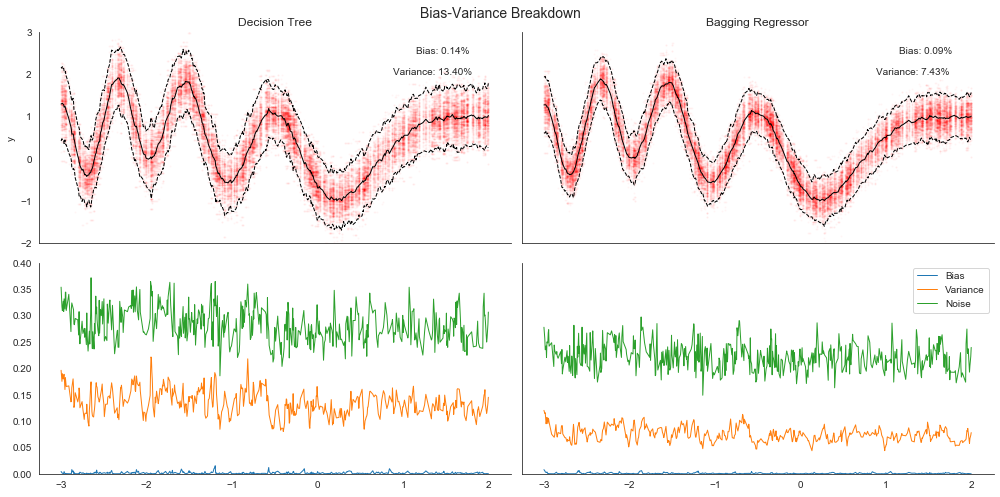

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 7), sharex=True, sharey='row')
axes = axes.flatten()
idx = pd.IndexSlice

for i, (model, data) in enumerate(predictions.items()):
    mean, std = data.mean(1), data.std(1).mul(2) #对每列计算预测的均值、标准差
    (pd.DataFrame([mean.sub(std), mean, mean.add(std)]).T #计算均值上下两个标准差带
     .sort_index()
     .plot(style=['k--', 'k-', 'k--'], ax=axes[i], lw=1, legend=False, ylim=(-2, 3)))
    (data.stack().reset_index()
     .rename(columns={'level_0': 'x', 0: 'y'})
     .plot.scatter(x='x', y='y', ax=axes[i], alpha=.02, s=2, color='r', title=model))
    r = result[model] #提取模型的误差分解结果
    m = r.mean()
    kwargs = {'transform': axes[i].transAxes, 'fontsize':10}
    axes[i].text(x=.8, y=.9, s=f'Bias: {m.bias:.2%}', **kwargs) 
    axes[i].text(x=.75, y=.8, s=f'Variance: {m.variance:.2%}', **kwargs)
    #bagged regressor降低预测方差   
    
    (r.drop('error', axis=1).sort_index() #删除error列
     .rename(columns=str.capitalize) #列名开头字母大写
     .plot(ax=axes[i+2], lw=1, legend=False, stacked=True, ylim=(0, .4)))

axes[-1].legend(fontsize=10)
fig.suptitle('Bias-Variance Breakdown', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.93);